In [78]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from enum import IntEnum
import time

class Algorithms(IntEnum):
    LINEAR_REGRESSION = 0
    CNN = 1
    ANN = 2
    ANN_NOPCA = 3
    ALL = 4

WEBCAM_ID = 2
RESOLUTION = 32
ALGORITHM = Algorithms.LINEAR_REGRESSION
TARGET_COUNT = 6
TARGET_NAMES = ['smile', 'mouth_open', 'puff', 'frown', 'left', 'right']
FEATURE_COUNT = RESOLUTION * RESOLUTION  
BATCH_SIZE = 32  # Batch size for model training


FEATURE_COLUMNS = slice(0, FEATURE_COUNT)
LABEL_COLUMNS = slice(-2, None)


In [79]:
train_data = pd.read_csv('./training_set.csv')
X_train = train_data.iloc[:, :-TARGET_COUNT]
y_train = train_data.iloc[:, -TARGET_COUNT:]
test_data = pd.read_csv('./test_set.csv')
X_test = test_data.iloc[:, :-TARGET_COUNT]
y_test = test_data.iloc[:, -TARGET_COUNT:]
train_data_pca = pd.read_csv('./training_set_pca.csv')
X_train_pca = train_data_pca.iloc[:, :-TARGET_COUNT]
test_data_pca = pd.read_csv('./test_set_pca.csv')
X_test_pca = test_data_pca.iloc[:, :-TARGET_COUNT]


In [80]:
# Linear regression

# Train a linear regression model to predict the multiple outputs
start_time = time.time()
regression_model = MultiOutputRegressor(LinearRegression()).fit(X_train_pca, y_train)
end_time = time.time()
lr_train_time = end_time - start_time
print(f"Time to train: {round(lr_train_time, 3)} s")
# Find training error
y_pred = regression_model.predict(X_train_pca)
lr_train_mse = mean_squared_error(y_train, y_pred)
print(f'Training error (MSE): {lr_train_mse}')

# Find test error
start_time = time.time()
y_pred = regression_model.predict(X_test_pca)
end_time = time.time()
lr_time_to_predict = end_time - start_time
lr_test_mse = mean_squared_error(y_test, y_pred)
print(f'Test error (MSE): {lr_test_mse}')
print(f'Time to predict test set: {round(lr_time_to_predict, 3)} s')

Time to train: 0.008 s
Training error (MSE): 0.01674216131187532
Test error (MSE): 0.016164379887499372
Time to predict test set: 0.0 s


In [98]:
# Convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Ensure that data contains the correct number of columns expected as per RESOLUTION and TARGET_COUNT
if len(train_data.columns) != RESOLUTION * RESOLUTION + TARGET_COUNT:
    print("Error: Data does not match the expected format.")

# Split the data
cnn_X = train_data.iloc[:, :-TARGET_COUNT].values
cnn_y = train_data.iloc[:, -TARGET_COUNT:].values

# Check if y contains more than one column and it's not already in the correct categorical format
if cnn_y.ndim == 1 or cnn_y.shape[1] == 1:
    cnn_y = to_categorical(cnn_y)  # This assumes y contains class indices as integers from 0 to num_classes-1

num_classes = cnn_y.shape[1]

# Reshape X to fit the model's input requirements: (num_samples, RESOLUTION, RESOLUTION, 1)
cnn_X = cnn_X.reshape(-1, RESOLUTION, RESOLUTION, 1)

# Normalize the pixel values
cnn_X = cnn_X.astype('float32') / 255.0

# Split the data
cnn_X_train, cnn_X_test, cnn_y_train, cnn_y_test = train_test_split(cnn_X, cnn_y, test_size=0.2, random_state=42)
# Define the CNN model architecture
#works best with 1 conv layer
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 1)),
    #MaxPooling2D(2, 2),# Max pooling layer
    #Conv2D(64, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 1)),
    #MaxPooling2D(2, 2),# Max pooling layer
    Flatten(),# flatten the 3D output to 1D
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # number of classes here
    #softmax activation function instead of sigmoid
])

# Compile the cnn_model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the cnn_model
start_time = time.time()
history = cnn_model.fit(cnn_X_train, cnn_y_train, epochs=18, batch_size=42, validation_data=(cnn_X_test, cnn_y_test))
end_time = time.time()
cnn_train_time = end_time - start_time
print(f'Time to train: {cnn_train_time} s')


# Find training error
y_pred = cnn_model.predict(X_train.values.reshape(-1, RESOLUTION, RESOLUTION, 1))
cnn_train_mse = mean_squared_error(y_train, y_pred)
print(f'Training error (MSE): {cnn_train_mse}')

# Find test error
start_time = time.time()
y_pred = cnn_model.predict(X_test.values.reshape(-1, RESOLUTION, RESOLUTION, 1))
end_time = time.time()
cnn_time_to_predict = end_time - start_time
cnn_test_mse = mean_squared_error(y_test, y_pred)
print(f'Test error (MSE): {cnn_test_mse}')
print(f'Time to predict test set: {round(cnn_time_to_predict, 3)} s')

Epoch 1/18


c:\Users\JacobSchool\Documents\Mouth-Tracker\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2841 - loss: 1.0197 - val_accuracy: 0.5556 - val_loss: 0.7784
Epoch 2/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5326 - loss: 0.7225 - val_accuracy: 0.6944 - val_loss: 0.5969
Epoch 3/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6267 - loss: 0.5274 - val_accuracy: 0.7153 - val_loss: 0.4724
Epoch 4/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6843 - loss: 0.4533 - val_accuracy: 0.6667 - val_loss: 0.4228
Epoch 5/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6286 - loss: 0.4694 - val_accuracy: 0.6736 - val_loss: 0.4984
Epoch 6/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6098 - loss: 0.4792 - val_accuracy: 0.6597 - val_loss: 0.4746
Epoch 7/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6177 - loss: 0.6044 - val_accuracy: 0.8194 - val_loss: 0.3692
Epoch 8/18
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6165 - loss: 0.5212 - val_accuracy: 0.5625 - val_loss: 0.

In [82]:
# Artificial neural network
from keras.models import Sequential
from keras.layers import Dense

# number of input and outputs respectively
n_features = X_train_pca.shape[1]
n_targets = y_train.shape[1]

ann_model = Sequential()
ann_model.add(Dense(4, input_dim=n_features, activation='relu'))
ann_model.add(Dense(n_targets, activation='linear')) # Output layer

# Compile
ann_model.compile(loss='mean_squared_error', optimizer='adam')
# Train
start_time = time.time()
ann_model.fit(X_train_pca, y_train, epochs=50, batch_size=10)
end_time = time.time()
ann_train_time = end_time - start_time
print(f'Time to train: {ann_train_time} s')

# Find training error
y_pred = ann_model.predict(X_train_pca)
ann_train_mse = mean_squared_error(y_train, y_pred)
print(f'Training error (MSE): {ann_train_mse}')

# Find test error
start_time = time.time()
y_pred = ann_model.predict(X_test_pca)
end_time = time.time()
ann_time_to_predict = end_time - start_time
ann_test_mse = mean_squared_error(y_test, y_pred)
print(f'Test error (MSE): {ann_test_mse}')
print(f'Time to predict test set: {round(ann_time_to_predict, 3)} s')


Epoch 1/50


c:\Users\JacobSchool\Documents\Mouth-Tracker\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 1.0738 
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.5948
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.3926
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.3000
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 0.2089
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.1832
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.1344
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 0.1106
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.0945
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.0799
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.0682
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.0587
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.0535
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0467
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.0462

In [83]:
# Artificial neural network (No PCA)
from keras.models import Sequential
from keras.layers import Dense

# number of input and outputs respectively
n_features = X_train.shape[1]
n_targets = y_train.shape[1]

annnopca_model = Sequential()
annnopca_model.add(Dense(4, input_dim=n_features, activation='relu'))
annnopca_model.add(Dense(n_targets, activation='linear')) # Output layer

# Compile
annnopca_model.compile(loss='mean_squared_error', optimizer='adam')
# Train
start_time = time.time()
annnopca_model.fit(X_train, y_train, epochs=50, batch_size=10)
end_time = time.time()
annnopca_train_time = end_time - start_time
print(f'Time to train: {annnopca_train_time} s')

# Find training error
y_pred = annnopca_model.predict(X_train)
annnopca_train_mse = mean_squared_error(y_train, y_pred)
print(f'Training error (MSE): {annnopca_train_mse}')

# Find test error
start_time = time.time()
y_pred = annnopca_model.predict(X_test)
end_time = time.time()
annnopca_time_to_predict = end_time - start_time
annnopca_test_mse = mean_squared_error(y_test, y_pred)
print(f'Test error (MSE): {annnopca_test_mse}')
print(f'Time to predict test set: {round(annnopca_time_to_predict, 3)} s')


Epoch 1/50


c:\Users\JacobSchool\Documents\Mouth-Tracker\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - loss: 0.1024 
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.0619
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.0585
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.0634
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0604
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0600
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0605
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0626
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.0636
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.0605
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.0605
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0633
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.0619
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.0615
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0609

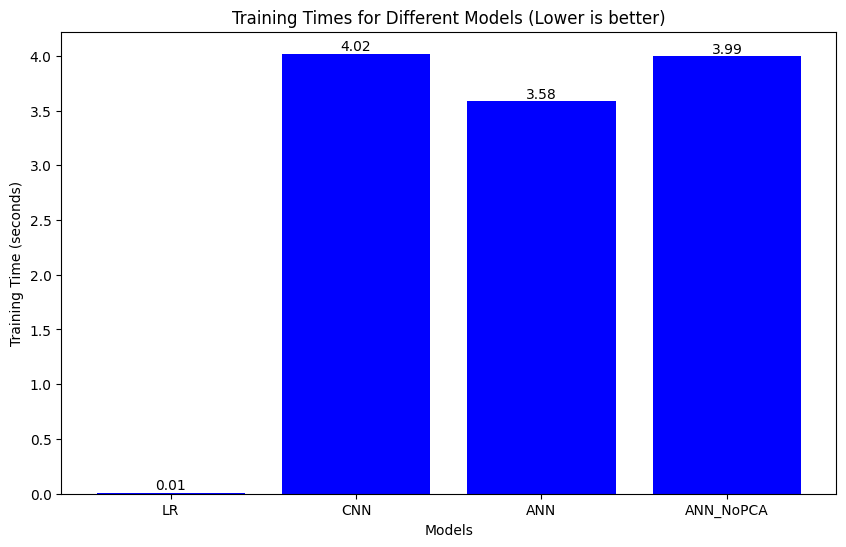

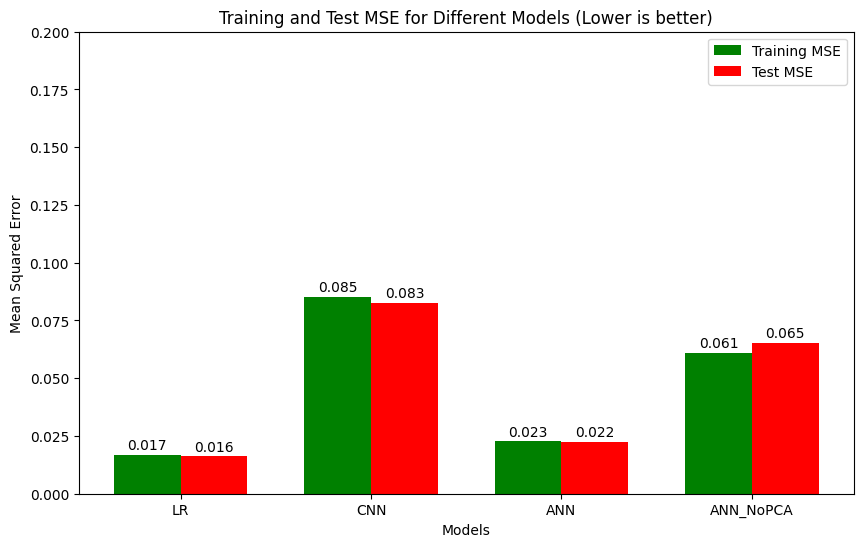

In [99]:
# Plotting
# Use matplotlib to compare:
# lr_train_time, cnn_train_time, ann_train_time, annnopca_train_time
# lr_train_mse, cnn_train_mse, ann_train_mse, annnopca_train_mse
# lr_test_mse, cnn_test_mse, ann_test_mse, annnopca_test_mse
# Each variable is a float

import matplotlib.pyplot as plt

# Define the models and their corresponding training times and MSEs
models = ['LR', 'CNN', 'ANN', 'ANN_NoPCA']
train_times = [lr_train_time, cnn_train_time, ann_train_time, annnopca_train_time]
train_mses = [lr_train_mse, cnn_train_mse, ann_train_mse, annnopca_train_mse]
test_mses = [lr_test_mse, cnn_test_mse, ann_test_mse, annnopca_test_mse]

# Plot training times
plt.figure(figsize=(10, 6))
bars = plt.bar(models, train_times, color='blue')
plt.title('Training Times for Different Models (Lower is better)')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
# Add the actual values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.show()

# Plot training and test MSEs
# Define the width of the bars and the positions of the bar centers
bar_width = 0.35
index = np.arange(len(models))
fig, ax = plt.subplots(figsize=(10, 6))
train_bar = ax.bar(index - bar_width/2, train_mses, bar_width, color='green', label='Training MSE')
test_bar = ax.bar(index + bar_width/2, test_mses, bar_width, color='red', label='Test MSE')
for bar in train_bar:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + .001, round(yval, 3), ha='center', va='bottom')
for bar in test_bar:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + .001, round(yval, 3), ha='center', va='bottom')
ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Training and Test MSE for Different Models (Lower is better)')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()
#ax.set_ylim([0, 0.2])

# Show the plot
plt.show()